#### EDA, Preprocessing, and Modeling

##### Imported Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 

# Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error 


### Exploratory Data Analysis

##### Read in DataFrame

In [2]:
# subreddit 1: Marvel 
marvel = pd.read_csv('marvel_post.csv')
# subreddit 2: dc_cinematic
dc_cinematic = pd.read_csv('dc_cinematic_post.csv')

###### subreddit 1: Marvel

In [3]:
marvel.head()

,created_utc,title,self_text,subreddit
0,1.697693e+09,Do the MCU movies still have a continuous story?,I watched all of the movies up to Endgame and ...,Marvel
1,1.697693e+09,Stumbled across this sealed box while cleaning...,NaN,Marvel
2,1.697692e+09,Here's the first part of the roster for my Ave...,NaN,Marvel
3,1.697691e+09,Supreme Iron man / art by ktrew,NaN,Marvel
4,1.697688e+09,Why tf is he alive still?,Just saw the marvels trailer pop up on TV. Has...,Marvel


###### subreddit 2: dc_cinematic

In [4]:
dc_cinematic.head()

,created_utc,title,self_text,subreddit
0,1.697693e+09,Early idea for The Flash helmet. Art by Ed Nat...,NaN,DC_Cinematic
1,1.697690e+09,McFarlane Toys DC Multiverse Batman & Robin wa...,NaN,DC_Cinematic
2,1.697684e+09,What style of suit should Corenswet have in Su...,NaN,DC_Cinematic
3,1.697678e+09,"After the Crisis scene, and the events of the ...","How do you think a team up would play out, esp...",DC_Cinematic
4,1.697677e+09,Remember when Batman didn’t kill Two-face? Gra...,NaN,DC_Cinematic


##### Summary Statistic

In [5]:
# subreddit 1: Marvel
marvel.describe(include='object')

,title,self_text,subreddit
count,990,453,990
unique,990,453,1
top,Do the MCU movies still have a continuous story?,I watched all of the movies up to Endgame and ...,Marvel
freq,1,1,990


In [6]:
marvel.isna().sum()

created_utc      0
title            0
self_text      537
subreddit        0
dtype: int64

In [7]:
#subreddit 2: dc_cinematic
dc_cinematic.describe(include='object')

,title,self_text,subreddit
count,977,402,977
unique,976,402,1
top,Batman No Way Home fan edit where all 4 Batmen...,"How do you think a team up would play out, esp...",DC_Cinematic
freq,2,1,977


In [8]:
dc_cinematic.isna().sum()

created_utc      0
title            0
self_text      575
subreddit        0
dtype: int64

> Looking at both subreddits, we see that from the self_text column, we have about half of the data missing. so will decide to work on the titles of the posts since we do have enough valuable data. 

##### Running Analysis on 'title' feature

###### Checking for length of post

In [9]:
# make column for post_length
dc_cinematic['post_length'] = dc_cinematic['title'].map(len)
marvel['post_length'] = marvel['title'].map(len)

###### Checking for word count per post

In [10]:
# make column for post_word_count
marvel['post_word_count'] = marvel['title'].map(lambda x: len(x.split()))
dc_cinematic['post_word_count'] = dc_cinematic['title'].map(lambda x: len(x.split()))

###### Ratio of post length to word count

In [11]:
# create a ratio
marvel['ratio'] = marvel.post_length/marvel.post_word_count
dc_cinematic['ratio'] = dc_cinematic.post_length/dc_cinematic.post_word_count

In [12]:
marvel.head(1)

,created_utc,title,self_text,subreddit,post_length,post_word_count,ratio
0,1.697693e+09,Do the MCU movies still have a continuous story?,I watched all of the movies up to Endgame and ...,Marvel,48,9,5.333333


In [13]:
dc_cinematic.head(1)

,created_utc,title,self_text,subreddit,post_length,post_word_count,ratio
0,1.697693e+09,Early idea for The Flash helmet. Art by Ed Nat...,NaN,DC_Cinematic,52,10,5.2


In [14]:
marvel.describe().T

,count,mean,std,min,25%,50%,75%,max
created_utc,990.0,1.696913e+09,496569.702743,1.695950e+09,1.696486e+09,1.696960e+09,1.697342e+09,1.697693e+09
post_length,990.0,6.184545e+01,41.660957,3.000000e+00,3.400000e+01,5.200000e+01,7.600000e+01,3.000000e+02
post_word_count,990.0,1.087980e+01,7.638753,1.000000e+00,6.000000e+00,9.000000e+00,1.400000e+01,5.500000e+01
ratio,990.0,5.879527e+00,1.148842,3.000000e+00,5.214286e+00,5.666667e+00,6.333333e+00,1.600000e+01


In [15]:
dc_cinematic.describe().T

,count,mean,std,min,25%,50%,75%,max
created_utc,977.0,1.694392e+09,1.588542e+06,1.692038e+09,1.692982e+09,1.694154e+09,1.695619e+09,1.697693e+09
post_length,977.0,7.319857e+01,4.606659e+01,5.000000e+00,4.300000e+01,6.200000e+01,9.000000e+01,2.990000e+02
post_word_count,977.0,1.292938e+01,8.052220e+00,1.000000e+00,8.000000e+00,1.100000e+01,1.600000e+01,5.700000e+01
ratio,977.0,5.724209e+00,8.611122e-01,3.000000e+00,5.166667e+00,5.642857e+00,6.125000e+00,1.050000e+01


###### Top 10: post word count

In [16]:
# Top 10: marvel longest post
marvel.sort_values(by='post_word_count', ascending=False)[['subreddit','title','post_word_count','post_length','ratio']].head(10)

,subreddit,title,post_word_count,post_length,ratio
948,Marvel,So I think we can all agree that Wanda’s not d...,55,278,5.054545
234,Marvel,if marvel were to animate a comic (the way jap...,51,273,5.352941
345,Marvel,I always thought it would be cool if Marvel ev...,50,283,5.660000
42,Marvel,"[Artwork]. Scarlet Witch #9. Seriously, they'v...",48,300,6.250000
14,Marvel,You have a choice to make: Doom is dead and yo...,44,234,5.318182
655,Marvel,What do you think is the chance that the chara...,43,204,4.744186
973,Marvel,I've seen a lot of people at this point wantin...,43,226,5.255814
521,Marvel,I remember this art work being the staple of m...,41,246,6.000000
705,Marvel,At least the avengers bothered to show up at D...,41,229,5.585366
752,Marvel,I’m curious. How tough are the Yancy Street Ga...,40,197,4.925000


In [17]:
# Top 10: dc_cinematic longest post
dc_cinematic.sort_values(by='post_word_count', ascending=False)[['subreddit','title','post_word_count','post_length','ratio']].head(10)

,subreddit,title,post_word_count,post_length,ratio
33,DC_Cinematic,I have always wondered who it was Clark was pr...,57,299,5.245614
373,DC_Cinematic,Tim Burton breaks silence on The Flash using h...,51,293,5.745098
518,DC_Cinematic,Mr. Mind and the Monster Society of Evil shoul...,50,286,5.720000
219,DC_Cinematic,"""And, yes, some actors will be playing charact...",49,273,5.571429
701,DC_Cinematic,That’s it! #BlueBeetle had #5 best hold in DCE...,48,275,5.729167
224,DC_Cinematic,"Fun Fact: Birdman, an Oscar-winning movie rele...",48,299,6.229167
820,DC_Cinematic,When James Gunn cast David Dastmalchian as sup...,46,267,5.804348
680,DC_Cinematic,"With actuals out, #BlueBeetle was the first ch...",46,278,6.043478
945,DC_Cinematic,"James Gunn praises WONDER WOMAN HISTORIA as ""a...",46,264,5.739130
658,DC_Cinematic,"I am very curious, for people living in foreig...",46,246,5.347826


##### Top 20: common words

###### CountVectorizing subreddits

In [18]:
# Top 20: marvel common words
cv = CountVectorizer(stop_words='english')
cv.fit(marvel['title'])

marvel_post_cv = cv.transform(marvel['title'])
marvel_post_df = pd.DataFrame(marvel_post_cv.todense(), columns=cv.get_feature_names_out())

In [19]:
marvel_top_words = pd.DataFrame(marvel_post_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
marvel_top_words.T;

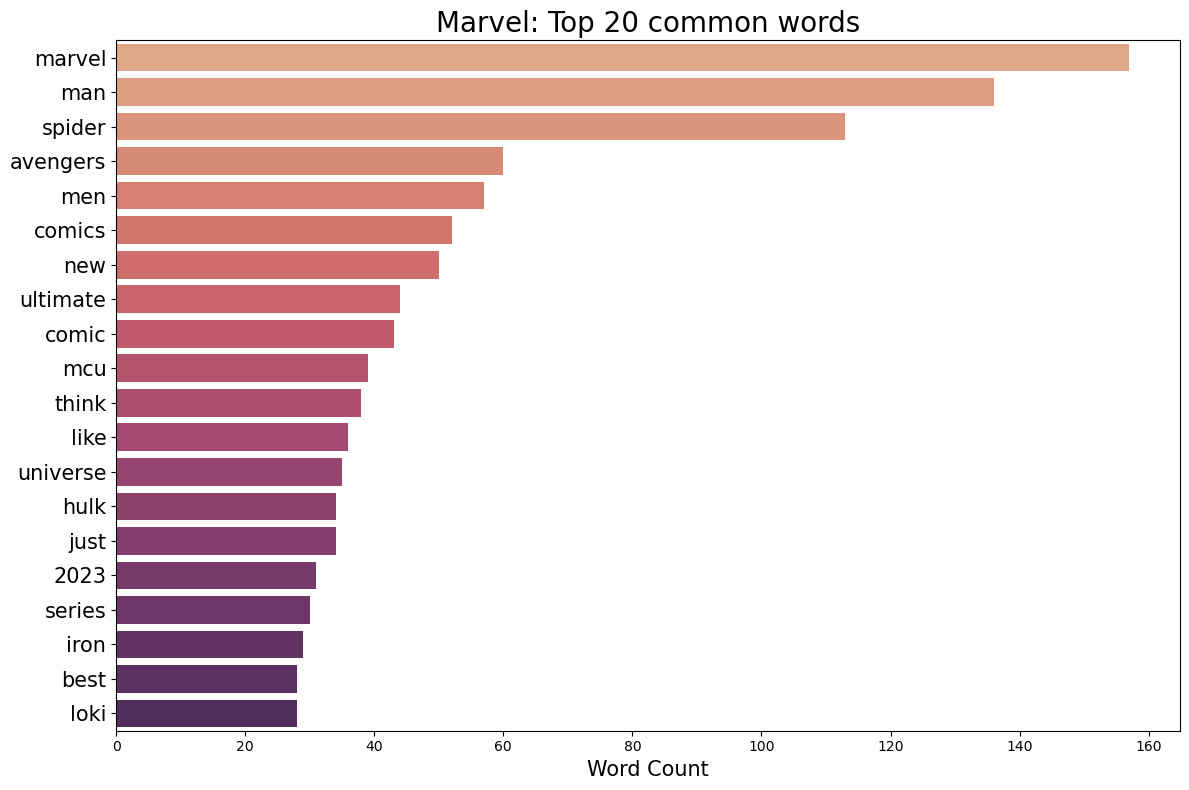

In [20]:
# top 20: marvel common words graph
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Count', y=marvel_top_words.index , data=marvel_top_words, palette = "flare")
plt.title('Marvel: Top 20 common words',fontsize=20)
plt.xlabel('Word Count', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

In [21]:
# dc_cinematic top 20 common word
cv = CountVectorizer(stop_words='english')
cv.fit(dc_cinematic['title'])

dc_cinematic_post_cv = cv.transform(dc_cinematic['title'])
dc_cinematic_post_df = pd.DataFrame(dc_cinematic_post_cv.todense(), columns=cv.get_feature_names_out())

In [22]:
dc_cinematic_top_words = pd.DataFrame(dc_cinematic_post_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
dc_cinematic_top_words.T;

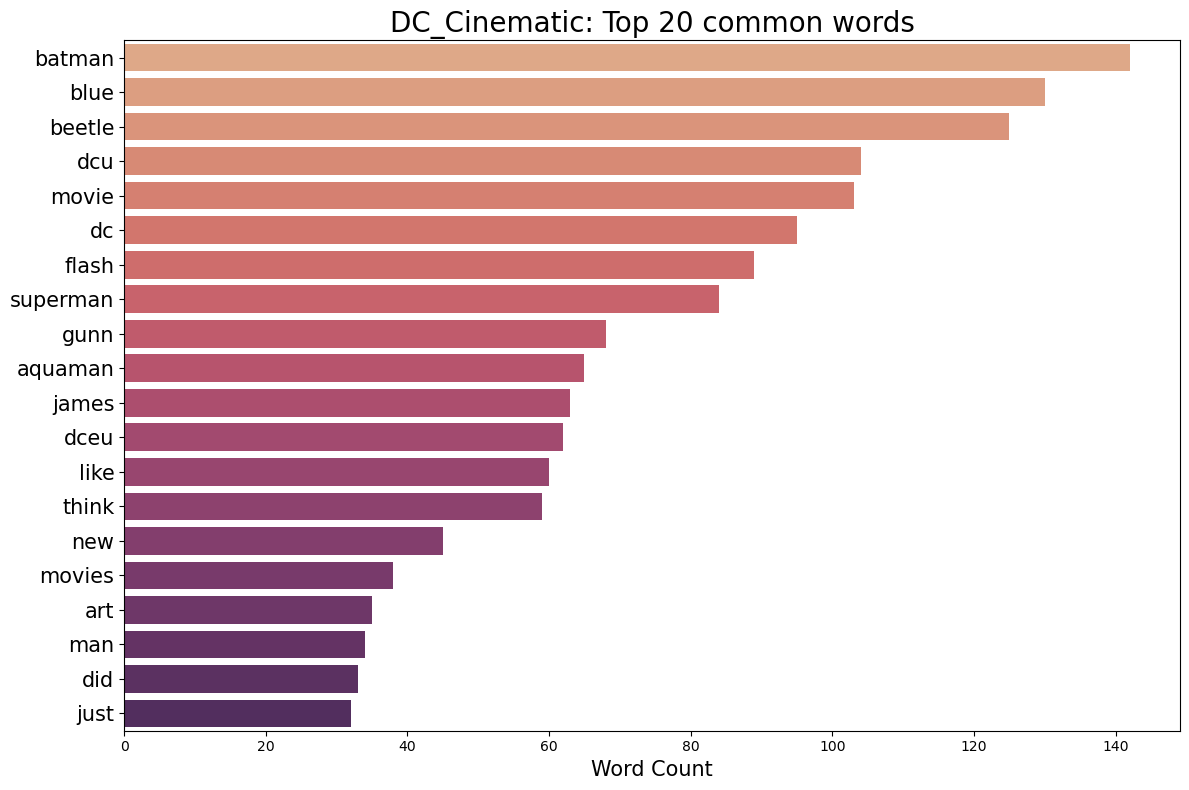

In [23]:
# top 20: marvel common words graph
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Count', y=dc_cinematic_top_words.index , data=dc_cinematic_top_words, palette = "flare")
plt.title('DC_Cinematic: Top 20 common words',fontsize=20)
plt.xlabel('Word Count', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

##### Top 20: subreddits Trigram

In [24]:
# Marvel top 20: trigrams
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')
cv_trigrams.fit(marvel['title'])

trigrams_cv = cv_trigrams.transform(marvel['title'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names_out())

marvel_top_triwords = pd.DataFrame(trigrams_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
marvel_top_triwords;

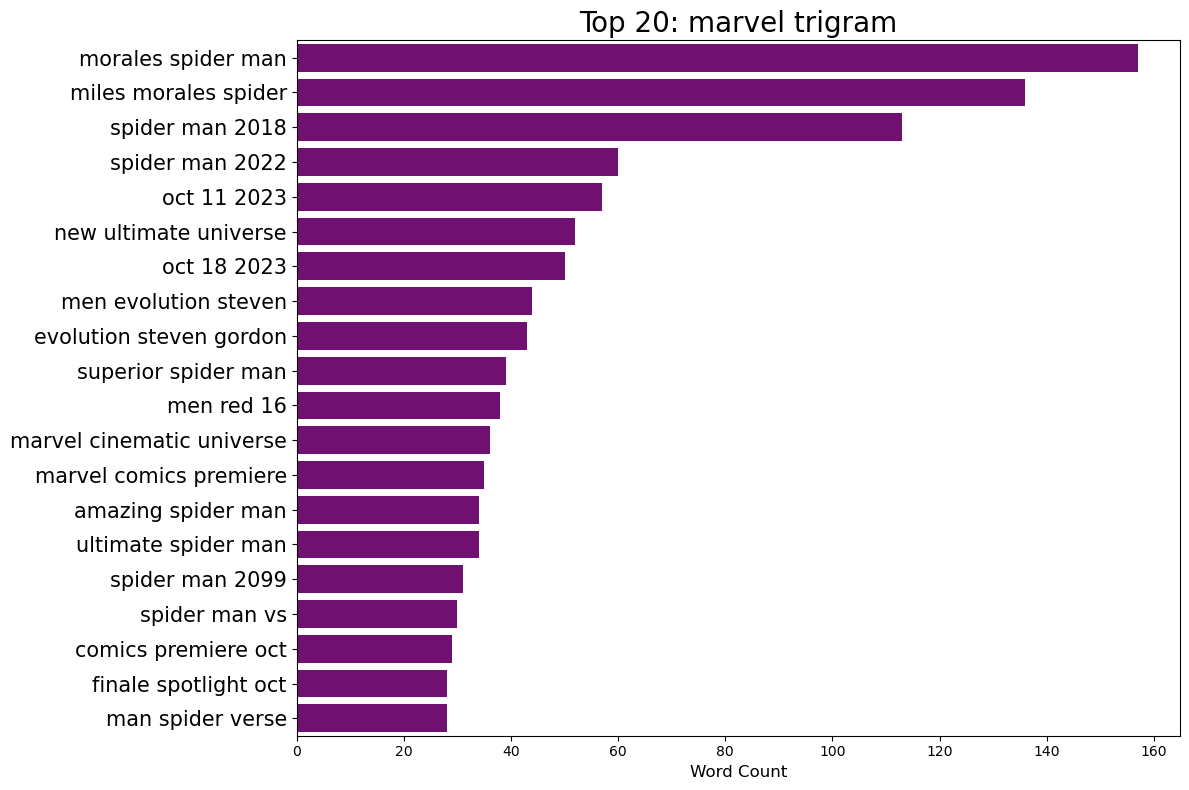

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Count', y=marvel_top_triwords.index , data=marvel_top_words, color='purple')
plt.title('Top 20: marvel trigram',fontsize=20)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()

In [26]:
# dc_cinematic top 20: trigrams
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')
cv_trigrams.fit(dc_cinematic['title'])

trigrams_cv = cv_trigrams.transform(dc_cinematic['title'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names_out())

dc_cinematic_top_triwords = pd.DataFrame(trigrams_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
dc_cinematic_top_triwords;

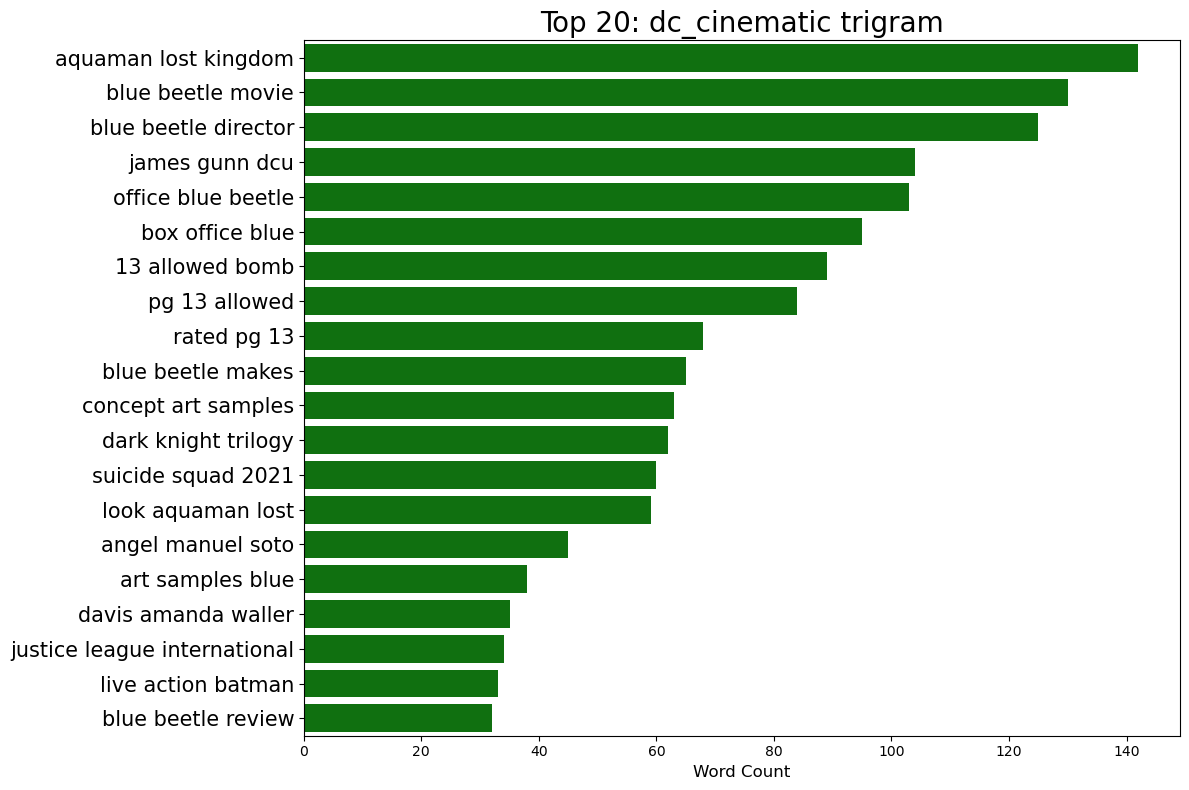

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Count', y=dc_cinematic_top_triwords.index , data=dc_cinematic_top_words, color='green')
plt.title('Top 20: dc_cinematic trigram',fontsize=20)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()

### Preprocessing  

###### Merging DataFrames

> Dropping all columns, leaving only necessary features. As a result, our title feature will be our X fetaure and the subreddit feature will be our y target variable.

In [28]:
marvel.drop(marvel.columns[[0,2,4,5,6]], axis=1, inplace=True)
marvel.head()

,title,subreddit
0,Do the MCU movies still have a continuous story?,Marvel
1,Stumbled across this sealed box while cleaning...,Marvel
2,Here's the first part of the roster for my Ave...,Marvel
3,Supreme Iron man / art by ktrew,Marvel
4,Why tf is he alive still?,Marvel


In [29]:
dc_cinematic.drop(dc_cinematic.columns[[0,2,4,5,6]], axis=1, inplace=True)
dc_cinematic.head()

,title,subreddit
0,Early idea for The Flash helmet. Art by Ed Nat...,DC_Cinematic
1,McFarlane Toys DC Multiverse Batman & Robin wa...,DC_Cinematic
2,What style of suit should Corenswet have in Su...,DC_Cinematic
3,"After the Crisis scene, and the events of the ...",DC_Cinematic
4,Remember when Batman didn’t kill Two-face? Gra...,DC_Cinematic


In [30]:
# merging DataFrames
subreddits = pd.concat([marvel, dc_cinematic], ignore_index = True)

In [31]:
subreddits.shape

(1967, 2)

In [32]:
subreddits.head()

,title,subreddit
0,Do the MCU movies still have a continuous story?,Marvel
1,Stumbled across this sealed box while cleaning...,Marvel
2,Here's the first part of the roster for my Ave...,Marvel
3,Supreme Iron man / art by ktrew,Marvel
4,Why tf is he alive still?,Marvel


##### Mapping X and y variables

In [33]:
#binarize the subreddit column
subreddits['subreddit'].replace({'Marvel': 1, 'DC_Cinematic': 0}, inplace =True)

In [34]:
X = subreddits['title']
y = subreddits['subreddit']

In [35]:
subreddits.head()

,title,subreddit
0,Do the MCU movies still have a continuous story?,1
1,Stumbled across this sealed box while cleaning...,1
2,Here's the first part of the roster for my Ave...,1
3,Supreme Iron man / art by ktrew,1
4,Why tf is he alive still?,1


In [36]:
#saving combined DataFrame to csv
subreddits.to_csv('combined_subreddits.csv', index = False)

##### Tokenizing 

In [37]:
#Instantiate tokenizer
tokenizer = RegexpTokenizer(r'[A-z]+')

In [38]:
token = subreddits['title'].copy()

In [39]:
token.head()

0     Do the MCU movies still have a continuous story?
1    Stumbled across this sealed box while cleaning...
2    Here's the first part of the roster for my Ave...
3                      Supreme Iron man / art by ktrew
4                            Why tf is he alive still?
Name: title, dtype: object

In [40]:
tokens = [" ".join(tokenizer.tokenize(post.lower())) for post in token]

In [41]:
tokens[:3]

['do the mcu movies still have a continuous story',
 'stumbled across this sealed box while cleaning the garage the other day box has seen better day but still cool nonetheless',
 'here s the first part of the roster for my avengers redesign']

##### Lemmatize

In [42]:
#Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [43]:
lemma_token = [[lemmatizer.lemmatize(word) for word in post.split(' ')] for post in tokens]

In [44]:
#looking at both token and lemmatized token
list(zip(tokens, lemma_token))[:3]

[('do the mcu movies still have a continuous story',
  ['do', 'the', 'mcu', 'movie', 'still', 'have', 'a', 'continuous', 'story']),
 ('stumbled across this sealed box while cleaning the garage the other day box has seen better day but still cool nonetheless',
  ['stumbled',
   'across',
   'this',
   'sealed',
   'box',
   'while',
   'cleaning',
   'the',
   'garage',
   'the',
   'other',
   'day',
   'box',
   'ha',
   'seen',
   'better',
   'day',
   'but',
   'still',
   'cool',
   'nonetheless']),
 ('here s the first part of the roster for my avengers redesign',
  ['here',
   's',
   'the',
   'first',
   'part',
   'of',
   'the',
   'roster',
   'for',
   'my',
   'avenger',
   'redesign'])]

In [45]:
lemma_tokens = [" ".join(post) for post in lemma_token]

In [46]:
lemma_tokens[:3]

['do the mcu movie still have a continuous story',
 'stumbled across this sealed box while cleaning the garage the other day box ha seen better day but still cool nonetheless',
 'here s the first part of the roster for my avenger redesign']

##### Stemming

In [47]:
#Instantiate PorterStemmer.
p_stemmer = PorterStemmer()

In [48]:
# stem tokens, use spit to do each word separatly
tokens_stem = [[p_stemmer.stem(word) for word in post.split(' ')] for post in tokens]

In [49]:
#change post to stemmed tokens
stemmed_tokens = [" ".join(post) for post in tokens_stem]

In [50]:
subreddits.head()

,title,subreddit
0,Do the MCU movies still have a continuous story?,1
1,Stumbled across this sealed box while cleaning...,1
2,Here's the first part of the roster for my Ave...,1
3,Supreme Iron man / art by ktrew,1
4,Why tf is he alive still?,1


##### Token Model 

In [51]:
token_model = subreddits['title']

In [52]:
#Instantiate tokenizer
tokenizer_model = RegexpTokenizer(r'[A-z]+')

In [53]:
# Run tokenizer, use join method  
tokens_model = [" ".join(tokenizer_model.tokenize(post.lower())) for post in token_model]

In [54]:
#Instantiate PorterStemmer.
p_stemmer_model = PorterStemmer()

In [55]:
# stem token
stem_model = [[p_stemmer_model.stem(word) for word in post.split(' ')] for post in tokens_model]

In [56]:
stemmed_tokens_model = [" ".join(post) for post in stem_model]

In [57]:
# replacing title data to stemmed model
subreddits['title'] = stemmed_tokens_model

In [58]:
subreddits.head(10)

,title,subreddit
0,do the mcu movi still have a continu stori,1
1,stumbl across thi seal box while clean the gar...,1
2,here s the first part of the roster for my ave...,1
3,suprem iron man art by ktrew,1
4,whi tf is he aliv still,1
5,doe anyon know who the hero on the top left th...,1
6,doe anyon have ani graphic novel recommend foc...,1
7,what s your favorit hellfir gala look,1
8,loki s episod discuss spoiler,1
9,oc get readi for friday,1


#### Baseline Scoring

###### create X and y features

In [59]:
X = subreddits['title']
y = subreddits['subreddit']

###### Train-test Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=42)          

In [61]:
X_train.head()

1916                                beetl bro it s happen
873                                spider man draw i made
1420      mytimetoshinehello flash s rogu come to the dcu
882     in your opinion who is the most underr marvel ...
491                                 wolverin fanart by me
Name: title, dtype: object

In [62]:
y_test.value_counts(normalize = True)

1    0.502538
0    0.497462
Name: subreddit, dtype: float64

> The baseline accuracy is about 50/50  

#### Logistic Regression Model

In [63]:
# Instantiatie Pipeline with TfidfVectorizer() & LogisticRegression()
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()), 
    ('lr', LogisticRegression(solver = 'liblinear', random_state = 42))])

In [64]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('lr',
                 LogisticRegression(random_state=42, solver='liblinear'))])>

In [65]:
#got our parameters 
pipe_params = {
    'vectorizer__max_features': [1000, 2000,], 
    'vectorizer__ngram_range': [(1,1), (1,2)],
    "vectorizer__norm":         ['l1', 'l2'], 
    "vectorizer__stop_words":   ['english'],
    'lr__penalty':              ['l1', 'l2'],
    'lr__C':                    [2.0],
    
}

In [66]:
# Transform to GridSearchCV
gs = GridSearchCV(pipe, param_grid = pipe_params,cv = 5)

In [67]:
# fit model
gs.fit(X_train, y_train);

In [68]:
gs.best_score_

0.9021130320493377

In [69]:
gs.best_params_

{'lr__C': 2.0,
 'lr__penalty': 'l2',
 'vectorizer__max_features': 1000,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': 'english'}

In [70]:
#Save best model as gs_model.
gs_model = gs.best_estimator_

In [71]:
# Accuracy training score
gs_model.score(X_train, y_train)

0.9732994278448824

In [72]:
# Accuracy testing score
gs_model.score(X_test, y_test)

0.934010152284264

> The LogRegression model accuracy score on our testing data set is about 0.934.

#### LogRegression: Confusion Matrix

In [73]:
# test predictions
preds_test = gs.predict(X_test)

In [74]:
# create matrix
cm = confusion_matrix(y_test, preds_test) 

In [75]:
# Creating a dataframe for our matrix
pd.DataFrame(data = cm, 
             columns = ['Predicted dc_cinematic','Predicted marvel'],
             index = ['Actual dc_cinematic','Actual marvel'])

,Predicted dc_cinematic,Predicted marvel
Actual dc_cinematic,180,16
Actual marvel,10,188


#### Bernoulli NB Model

In [76]:
# Transformer is TfidfVectorizer
tvec = TfidfVectorizer()


In [77]:
#creating bag of words with dataframe 
data = pd.DataFrame(tvec.fit_transform(X_train).toarray(), 
                  columns=tvec.get_feature_names_out())

In [78]:
# Transformer training and testing feature
X_train = tvec.transform(X_train)
X_test = tvec.transform(X_test)

In [79]:
# Instantiatie the model
br = BernoulliNB()

In [80]:
# Fit the model
br.fit(X_train, y_train);

In [81]:
# Accuracy training score
br.score(X_train, y_train)

0.9574062301335029

In [82]:
# Accuracy testing score
br.score(X_test, y_test)

0.9213197969543148

> The accuracy score on our testing data set is about 0.921.

#### Bernoulli NB: Confusion Matrix

In [83]:
# test predictions
preds_test_1 = br.predict(X_test)

In [84]:
# Creating our matrix
cm_1 = confusion_matrix(y_test, preds_test_1)  

In [85]:
# Creating a dataframe for our matrix
pd.DataFrame(data = cm_1, 
             columns = ['Predicted dc_cinematic','Predicted marvel'],
             index = ['Actual dc_cinematic','Actual marvel'])

,Predicted dc_cinematic,Predicted marvel
Actual dc_cinematic,174,22
Actual marvel,9,189


#### Bagged Decision Tree

In [86]:
# Instantiate BaggingClassifier
bag = BaggingClassifier(random_state = 42)

In [87]:
# Fit the model
bag.fit(X_train, y_train);

In [88]:
# Accuracy training score
bag.score(X_train, y_train)

0.9936427209154481

In [89]:
# Accuracy testing score
bag.score(X_test, y_test)

0.8934010152284264

> The accuracy score on our testing data set is about 0.893.

#### BDT: Confusion Matrix

In [94]:
# test predictions
preds_test_2 = br.predict(X_test)

In [95]:
# Creating our matrix
cm_2 = confusion_matrix(y_test, preds_test_1) 

In [96]:
# Creating a dataframe for our matrix
pd.DataFrame(data = cm_2, 
             columns = ['Predicted dc_cinematic','Predicted marvel'],
             index = ['Actual dc_cinematic','Actual marvel'])

,Predicted dc_cinematic,Predicted marvel
Actual dc_cinematic,174,22
Actual marvel,9,189


#### Random Forest Model

In [97]:
# Instantiatie RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)

In [98]:
#parameters 
rf_params = {
    'n_estimators': [110, 150],
    'max_depth': [None, 4, 6],
    'criterion': ['gini']
}

In [99]:
# Transform to GridSearchCV
gs_2 = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [100]:
# Fit the model
gs_2.fit(X_train, y_train);

In [101]:
gs_2.best_params_

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}

In [102]:
# Save best model as gs_model.
gs_model_2 = gs_2.best_estimator_

In [103]:
# Accuracy training score
gs_model_2.score(X_train, y_train)

1.0

In [104]:
# Accuracy testing score
gs_model_2.score(X_test, y_test)

0.8908629441624365

> The accuracy score on our testing data set is about 0.891.

#### RFM: Confusion Matrix

In [105]:
#test prediction
preds_test_3 = gs_2.predict(X_test)

In [106]:
# Creating our matrix
cm_3 = confusion_matrix(y_test, preds_test_3) 

In [107]:
#create a data frame for matrix
pd.DataFrame(data = cm_3, 
             columns = ['Predicted Books', 'Predicted Moives'],
             index = ['Actual Books', 'Actual Movies'])

,Predicted Books,Predicted Moives
Actual Books,170,26
Actual Movies,17,181
